In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Python/ImpVol

Mounted at /content/drive
/content/drive/My Drive/Python/ImpVol


In [2]:
!pip install q pymc3
!pip install q tdqm
!pip install q cvxopt
!apt-get install libgmp-dev python3-dev
!pip install wheel
!pip install pypoman
!pip3 install tensorflow==2.2
!pip3 install keras==2.3.1
!pip install tensorflow-model-optimization==0.4.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=e3d2244d32e886a370bd8e07aff014f1d68a5d7740008507975751fbb0c16e9f
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built theano-pymc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1323 sha256=9bb85375b3fbe4ebf2b32a68ec168a45e5a62fc81eb0e2b3ae4e763c25a7fd47
  Stored in directory: /root/.cache/pip/wheels/86/cd/38/f96ed05dd8049e95d8fbeaa0587664eb001a1848979636b771
Successf

In [3]:
import os
import sys
import random

import pickle
import numpy as np
import pandas as pd
import scipy as sp
import joblib

from marketmodel.loader import DataOm
# from marketmodel import utils
# from marketmodel.neuralsde1 import Train
# from marketmodel.normalize import normalize
from marketmodel.alphaRNN import *

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Dense, Lambda

from google.colab import files

import csv
import warnings

# import arviz as az
# import pymc3 as pm
import seaborn as sns
from numpy import ndarray

from datetime import datetime
import matplotlib.dates

from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.layers import Layer, LSTM, GRU, SimpleRNN
from keras.models import load_model
from keras.models import Sequential
from keras import optimizers
from keras.regularizers import l1,l2
from keras import regularizers
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from keras.layers import Layer,RNN
from keras import backend as K
from keras import layers
import keras.layers
from keras.legacy import interfaces
from keras import *
from keras import Input, Model


from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

import statsmodels.api as sm

from glob import glob
import tensorflow_model_optimization as tfmot

Using TensorFlow backend.


In [4]:
# load OptionMetric data
ls_securityid = ['DAX']
in_dir = '/content/drive/My Drive/Python/ImpVol/input/'
dt = 1./365

curr_module = sys.modules[__name__]

ls_X = []
ls_dX = []
ls_S = []
ls_S_test = []
ls_C = []
ls_C_test = []
ls_dates = []
for i_securityid in range(len(ls_securityid)):
    securityid = ls_securityid[i_securityid]
    
    fname = in_dir + f'om_{securityid}.pkl'
    with open(fname, 'rb') as f:
        cache = pickle.load(f)
        
    for k, v in vars(cache).items():
        setattr(curr_module, k, v)
    
    ls_X.append(X)
    ls_dX.append(dX)
    ls_S.append(S)
    ls_S_test.append(S_test)
    ls_C.append(cs)
    ls_C_test.append(cs_test)
    ls_dates.append(dates_train)

# concatenate factor data
X = np.vstack(ls_X)
dX = np.vstack(ls_dX)

start = 1767
R = np.diff(np.log(S))
S = S[:-1]
R = R[(start-1):]
S = S[(start-1):]


# Create Date data for ploting
N_test = 1000
t = dates_train[0:-N_test]
t = t[0:-1]
t = t.astype(datetime)
Date = [datetime.strptime(x,'%Y-%m-%d') for x in t]

t_test = dates_train[-N_test:]
t_test = t_test[0:-1]
t_test = t_test.astype(datetime)
Date_test = [datetime.strptime(x,'%Y-%m-%d') for x in t_test]

# Split data to training and test
S_all = S
X_all = X
cs_all = cs
S_test = S[-N_test:]
X_test = X[-N_test:,:]
cs_test = cs[-N_test:,:]
S = S[0:-N_test]
X = X[0:-N_test,:]
cs = cs[0:-N_test,:]

In [5]:
V_norm_all = pd.read_csv('/content/drive/My Drive/Python/ImpVol/input/V_norm_all.csv')
R_all = pd.DataFrame(R,columns=['R'])
V_norm1 = V_norm_all.iloc[:,0:3]
V_norm2 = V_norm_all.iloc[:,-5:]

In [6]:
X1 = R_all.drop(R_all.tail(1).index,inplace=False)
X1.reset_index(drop=True, inplace=True)
X1_train = X1.iloc[:(-N_test),:]
X1_mean = X1_train.mean()
X1_std = X1_train.std()
X1 = (X1-X1_mean[0])/X1_std[0]
X_norm1 = V_norm1.drop(V_norm1.head(1).index,inplace=False)
X_norm1.reset_index(drop=True, inplace=True)
X_all1 = pd.concat([X1,X_norm1],axis=1)
X_norm2 = V_norm2.drop(V_norm2.head(1).index,inplace=False)
X_norm2.reset_index(drop=True, inplace=True)
X_all2 = pd.concat([X1,X_norm2],axis=1)

X_train1 = X_all1.iloc[:(-N_test),:]
X_test1 = X_all1.iloc[-N_test:,:]
X_train2 = X_all2.iloc[:(-N_test),:]
X_test2 = X_all2.iloc[-N_test:,:]

X_train = [X_train1,X_train2]
X_test = [X_test1,X_test2]

In [7]:
X_norm1.shape

(2519, 3)

In [8]:
X_train1.head(10)

,R,Comp 1,Comp 2,Comp 3
0,2.405849,1.879508,0.187964,-3.190381
1,0.125900,1.959160,0.104592,-2.745338
2,0.586034,1.860649,0.262087,-2.658205
3,-1.343507,2.092368,-0.098111,-2.321481
4,-0.895592,2.278085,-0.222501,-2.225722
5,-1.492997,2.389324,-0.244408,-2.460430
6,-1.027526,2.460882,-0.412803,-2.491362
7,-1.332693,2.640437,-0.182716,-2.361154
8,-3.512525,3.238969,-0.621365,-1.384932
9,-1.472276,3.332183,-0.383617,-1.228748


In [153]:
class Loss(object):
  def loss_lnS(y_true, y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]
    dX = y_true
            
    # compute log-likelihood
    l = tf.reduce_sum(-gamma + tf.square(dX - (alpha)*dt)*tf.exp(gamma)/dt )
    return l
  
  def loss_lnS_std(y_true,y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]

    nu = tf.math.floor(tf.reduce_min(tf.math.abs(y_pred[:,2])))
    nu = tf.cast(nu,tf.float32)
    # nu = tf.math.maximum(1,nu)
    
    dX = y_true

    l = tf.reduce_sum(-gamma + (nu+1)*tf.math.log(1+tf.square(dX - (alpha)*dt)*tf.exp(gamma)/dt/nu) +2*tf.math.lgamma(nu/2)-2*tf.math.lgamma((nu+1)/2)+tf.math.log(nu))

    return l

In [10]:
def get_lagged_features(value, n_steps, n_steps_ahead):
    """
    value: feature value to be lagged
    n_steps: number of lags, i.e. sequence length
    n_steps_ahead: forecasting horizon
    """
    lag_list = []
    for lag in range(n_steps+n_steps_ahead-1, n_steps_ahead-1, -1):
        lag_list.append(value.shift(lag))
    return pd.concat(lag_list, axis=1)

In [11]:
use_features1=['R','Comp 1','Comp 2','Comp 3']
use_features2=['R','Comp 1.1','Comp 2.1','Comp 3.1','Comp 4','Comp 5']
n_steps_all = []
for feature in use_features1:
  pacf=sm.tsa.stattools.pacf(X_train1[feature], nlags=30)
  n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(X_train1[feature])))==False)[0][0] -1
  n_steps_all.append(n_steps)
for feature in use_features2:
  pacf=sm.tsa.stattools.pacf(X_train2[feature], nlags=30)
  n_steps=np.where(np.array(np.abs(pacf)>2.58/np.sqrt(len(X_train2[feature])))==False)[0][0] -1
  n_steps_all.append(n_steps)
n_steps = np.max(n_steps_all)
print(n_steps)

6


In [12]:
n_steps_ahead=1

target='R'

# For R
x_train_list1 = []
for use_feature in use_features1:
    x_train_reg1 = get_lagged_features(X_train1, n_steps, n_steps_ahead).dropna()
    x_train_list1.append(x_train_reg1)
x_train_reg1 = pd.concat(x_train_list1, axis=1)

col_ords1 = []
for i in range(n_steps):
    for j in range(len(use_features1)):
        col_ords1.append(i + j * n_steps)

x_train_reg1 = x_train_reg1.iloc[:, col_ords1]
y_train_reg = X_train1.loc[x_train_reg1.index, [target]].values
x_train_reg1 = np.reshape(x_train_reg1.values, (x_train_reg1.shape[0], np.int(x_train_reg1.shape[1] / len(use_features1)), len(use_features1)))
y_train_reg = np.reshape(y_train_reg, (y_train_reg.shape[0], 1, 1))

x_test_list1 = []
for use_feature in use_features1:
    x_test_reg1 = get_lagged_features(X_test1, n_steps,n_steps_ahead).dropna()
    x_test_list1.append(x_test_reg1)
x_test_reg1 = pd.concat(x_test_list1, axis=1)

x_test_reg1 = x_test_reg1.iloc[:, col_ords1]
y_test_reg = X_test1.loc[x_test_reg1.index, [target]].values
x_test_reg1 = np.reshape(x_test_reg1.values, (x_test_reg1.shape[0], np.int(x_test_reg1.shape[1]/len(use_features1)), len(use_features1)))

y_test_reg = np.reshape(y_test_reg, (y_test_reg.shape[0], 1, 1))

# For R^2
x_train_list2 = []
for use_feature in use_features2:
    x_train_reg2 = get_lagged_features(X_train2, n_steps, n_steps_ahead).dropna()
    x_train_list2.append(x_train_reg2)
x_train_reg2 = pd.concat(x_train_list2, axis=1)

col_ords2 = []
for i in range(n_steps):
    for j in range(len(use_features2)):
        col_ords2.append(i + j * n_steps)

x_train_reg2 = x_train_reg2.iloc[:, col_ords2]
#y_train_reg2 = X_train2.loc[x_train_reg2.index, [target]].values
x_train_reg2 = np.reshape(x_train_reg2.values, (x_train_reg2.shape[0], np.int(x_train_reg2.shape[1] / len(use_features2)), len(use_features2)))
#y_train_reg2 = np.reshape(y_train_reg2, (y_train_reg2.shape[0], 1, 1))

x_test_list2 = []
for use_feature in use_features2:
    x_test_reg2 = get_lagged_features(X_test2, n_steps,n_steps_ahead).dropna()
    x_test_list2.append(x_test_reg2)
x_test_reg2 = pd.concat(x_test_list2, axis=1)

x_test_reg2 = x_test_reg2.iloc[:, col_ords2]
#y_test_reg2 = X_test1.loc[x_test_reg2.index, [target]].values
x_test_reg2 = np.reshape(x_test_reg2.values, (x_test_reg2.shape[0], np.int(x_test_reg2.shape[1]/len(use_features2)), len(use_features2)))

#y_test_reg2 = np.reshape(y_test_reg2, (y_test_reg2.shape[0], 1, 1))
y_test_reg = np.squeeze(y_test_reg)
y_train_reg = np.squeeze(y_train_reg)

<ipython-input-12-1c5cc7f525fe>:19: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x_train_reg1 = np.reshape(x_train_reg1.values, (x_train_reg1.shape[0], np.int(x_train_reg1.shape[1] / len(use_features1)), len(use_features1)))
<ipython-input-12-1c5cc7f525fe>:30: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to r

In [13]:
print(x_train_reg1.shape,y_train_reg.shape,x_test_reg1.shape,y_test_reg.shape)
print(x_train_reg2.shape,y_train_reg.shape,x_test_reg2.shape,y_test_reg.shape)

(1513, 6, 4) (1513,) (994, 6, 4) (994,)
(1513, 6, 6) (1513,) (994, 6, 6) (994,)


In [14]:
X_train1.head(7)

,R,Comp 1,Comp 2,Comp 3
0,2.405849,1.879508,0.187964,-3.190381
1,0.125900,1.959160,0.104592,-2.745338
2,0.586034,1.860649,0.262087,-2.658205
3,-1.343507,2.092368,-0.098111,-2.321481
4,-0.895592,2.278085,-0.222501,-2.225722
5,-1.492997,2.389324,-0.244408,-2.460430
6,-1.027526,2.460882,-0.412803,-2.491362


In [15]:
X_train2.head(7)

,R,Comp 1.1,Comp 2.1,Comp 3.1,Comp 4,Comp 5
0,2.405849,1.870252,-0.677861,-0.514824,-0.383135,1.734234
1,0.125900,1.952728,-0.494699,0.028479,-0.153708,1.762419
2,0.586034,1.850884,-0.653798,-0.162866,0.093073,1.589823
3,-1.343507,2.090924,-0.225856,0.223750,-0.120117,1.710290
4,-0.895592,2.279848,-0.046060,0.809742,-0.341897,2.050877
5,-1.492997,2.391237,-0.052841,0.854907,-0.840209,2.194900
6,-1.027526,2.466263,0.107816,0.842500,-0.678661,2.345351


In [16]:
x_train_reg = np.concatenate((x_train_reg1,x_train_reg2),axis=2)
x_test_reg = np.concatenate((x_test_reg1,x_test_reg2),axis=2)
n_obs, lag, n_comp = x_train_reg.shape
n_comp1 = x_train_reg1.shape[2]
n_comp2 = x_train_reg2.shape[2]

In [17]:
def AlphaRNN_(n_units = 10, l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg.shape[1],x_train_reg.shape[2]))
  in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,x_train_reg1.shape[2]]))(inputs)
  in2 = Lambda(lambda x: tf.slice(x,[0,0,x_train_reg1.shape[2]],[-1,-1,-1]))(inputs)
  x1 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True)(in1)
  x2 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2.shape[1], x_train_reg2.shape[-1]), unroll=True)(in2)
  out1 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_lnS, optimizer='adam')
  return Mymodel

In [18]:
max_epoches=6000
batch_size=1000
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=100, min_delta=0.1, restore_best_weights=True)
params = {'alpharnn': {'model':'', 'function':AlphaRNN_,'l1_reg':0.0, 'H':10,'color': 'green', 'label': '$\\alpha$-RNN' }}

In [26]:
def custom_loss_function(y_true, y_pred):
    alpha = y_pred[:,0].astype('float32')
    gamma = y_pred[:,1].astype('float32')
            
    # compute log-likelihood
    score = -np.sum(-gamma + tf.square(y_true - (alpha)*dt)*tf.exp(gamma)/dt )


    return score

scorer = make_scorer(custom_loss_function, greater_is_better=True)

In [27]:
x_train_reg = x_train_reg.astype('float32')
y_train_reg = y_train_reg.astype('float32')

In [24]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20,50,100,150]
    l1_reg = [0, 0.001, 0.01, 0.1]
    tscv = TimeSeriesSplit(n_splits = 2)
    param_grid = dict(n_units=n_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']

        joblib.dump(grid, key + 'grid.pkl')

Streaming output truncated to the last 5000 lines.
 - 0s - loss: 1805842.0000
Epoch 4642/6000
 - 0s - loss: 1805842.0000
Epoch 4643/6000
 - 0s - loss: 1805842.0000
Epoch 4644/6000
 - 0s - loss: 1805842.0000
Epoch 4645/6000
 - 0s - loss: 1805842.0000
Epoch 4646/6000
 - 0s - loss: 1805842.0000
Epoch 4647/6000
 - 0s - loss: 1805841.7500
Epoch 4648/6000
 - 0s - loss: 1805841.7500
Epoch 4649/6000
 - 0s - loss: 1805841.7500
Epoch 4650/6000
 - 0s - loss: 1805841.7500
Epoch 4651/6000
 - 0s - loss: 1805841.6250
Epoch 4652/6000
 - 0s - loss: 1805841.6250
Epoch 4653/6000
 - 0s - loss: 1805841.6250
Epoch 4654/6000
 - 0s - loss: 1805841.6250
Epoch 4655/6000
 - 0s - loss: 1805841.6250
Epoch 4656/6000
 - 0s - loss: 1805841.6250
Epoch 4657/6000
 - 0s - loss: 1805841.6250
Epoch 4658/6000
 - 0s - loss: 1805841.6250
Epoch 4659/6000
 - 0s - loss: 1805841.6250
Epoch 4660/6000
 - 0s - loss: 1805841.6250
Epoch 4661/6000
 - 0s - loss: 1805841.6250
Epoch 4662/6000
 - 0s - loss: 1805841.6250
Epoch 4663/6000
 - 

In [28]:
#load your model for further usage
# joblib.load("model_file_name.pkl")

params

{'alpharnn': {'model': '',
  'function': <function __main__.AlphaRNN_(n_units=10, l1_reg=0, seed=0, dt=0.0027397260273972603)>,
  'l1_reg': 0.001,
  'H': 20,
  'color': 'green',
  'label': '$\\alpha$-RNN'}}

In [153]:
def AlphaRNN_(n_units = 10, l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg.shape[1],x_train_reg.shape[2]))
  in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,x_train_reg1.shape[2]]))(inputs)
  in2 = Lambda(lambda x: tf.slice(x,[0,0,x_train_reg1.shape[2]],[-1,-1,-1]))(inputs)
  x1 = AlphaRNN(n_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True)(in1)
  x2 = AlphaRNN(n_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2.shape[1], x_train_reg2.shape[-1]), unroll=True)(in2)
  x1 = Dense(128, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  x2 = Dense(128, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out1 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_lnS, optimizer='adam')
  return Mymodel

Streaming output truncated to the last 5000 lines.
1513/1513 [==============================] - 0s 65us/step - loss: 5285782.7684
Epoch 3502/6000
1513/1513 [==============================] - 0s 61us/step - loss: 5285779.3354
Epoch 3503/6000
1513/1513 [==============================] - 0s 52us/step - loss: 5285774.4700
Epoch 3504/6000
1513/1513 [==============================] - 0s 46us/step - loss: 5285771.0032
Epoch 3505/6000
1513/1513 [==============================] - 0s 45us/step - loss: 5285765.9597
Epoch 3506/6000
1513/1513 [==============================] - 0s 42us/step - loss: 5285762.4419
Epoch 3507/6000
1513/1513 [==============================] - 0s 41us/step - loss: 5285756.3732
Epoch 3508/6000
1513/1513 [==============================] - 0s 42us/step - loss: 5285752.4396
Epoch 3509/6000
1513/1513 [==============================] - 0s 41us/step - loss: 5285747.6332
Epoch 3510/6000
1513/1513 [==============================] - 0s 41us/step - loss: 5285742.5387
Epoch 3511/6000

0.00018505564

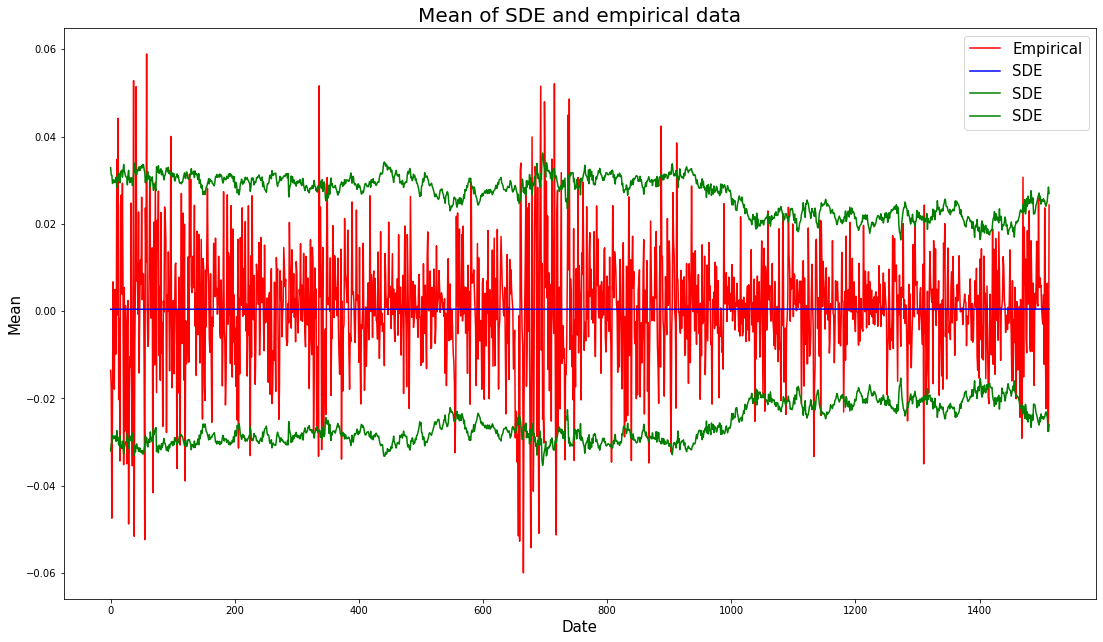

In [154]:
model_try = AlphaRNN_(n_units = 20, l1_reg =0.001, seed = 0, dt = dt)
model_try.fit(x_train_reg,y_train_reg,epochs=max_epoches, batch_size=batch_size,shuffle=False)



0.00018505567

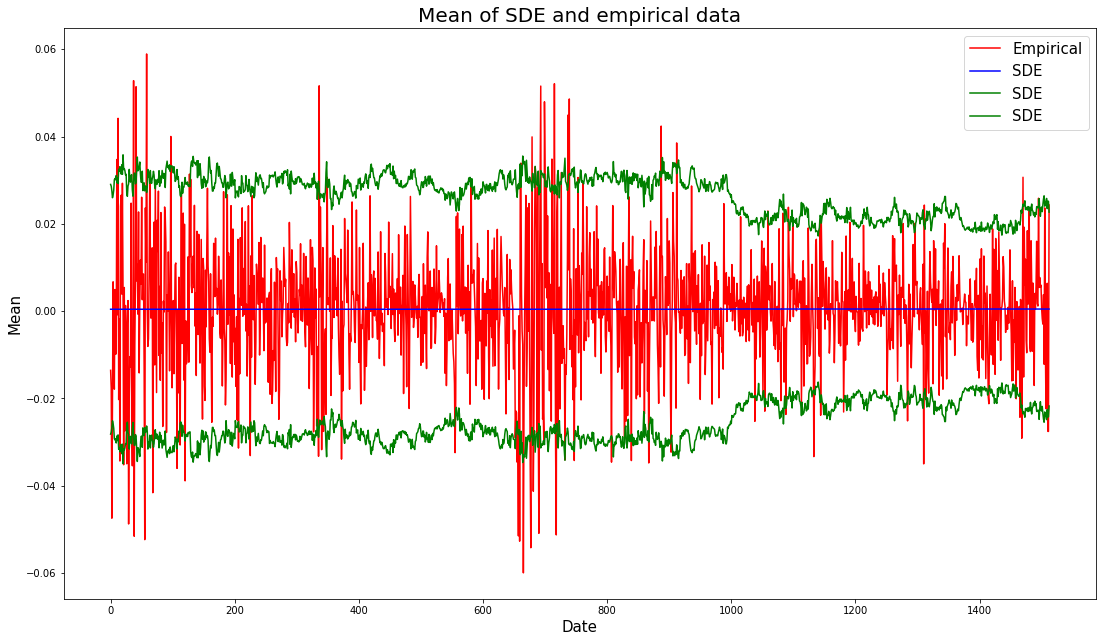

In [165]:
alpha = model_try.predict(x_train_reg)
mu = alpha[:,0]*dt*X1_std[0]+X1_mean[0]
sigma = np.exp(-alpha[:,1]/2)*X1_std[0]*np.sqrt(dt)

fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu,color='blue',label='SDE')
plt.plot(mu+1.95*sigma,color='green',label='SDE')
plt.plot(mu-1.95*sigma,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

np.mean((y_train_reg*X1_std[0]+X1_mean[0]-mu)**2)

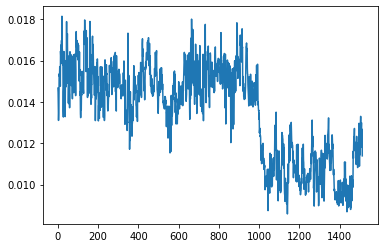

In [167]:
plt.plot(sigma)

In [156]:
# l1_reg': 0.001, n = 20
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger

for key in params.keys():
  rand_seed = 0
  tf.compat.v1.set_random_seed(rand_seed)
  model=params[key]['function'](params[key]['H'],params[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name[0] + '_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg,y_train_reg,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params[key]['model']=model


<Figure size 648x180 with 0 Axes>

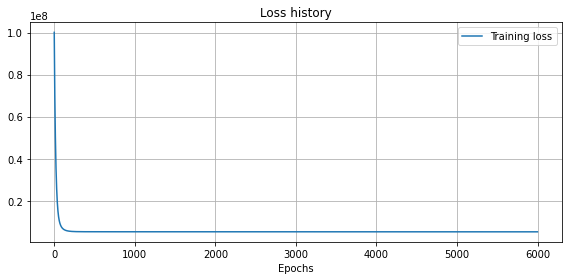

In [157]:
rand_seed = 0
fig = plt.figure(figsize=(9, 2.5))
for key in params.keys():
    model_name=key
    out_dir='output/checkpoint/'
    tag = out_dir + model_name[0] + '_' + str(rand_seed)
    csv_fname = tag + '_history.csv'
    df_hist = pd.read_csv(csv_fname, index_col=0)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.set_title(fr'Loss history')
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()


In [158]:
# for key in params.keys():
#   params[key]['model'].save(key + 'n6norm.hdf5', overwrite=True)  # creates a HDF5 file
# for key in params.keys():
#   params[key]['model']=load_model(key + '.hdf5')

In [159]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

# Print out the value of alpha \in [0,1] for the alpha-RNN model
model = params['alpharnn']['model']
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

for name, weight in zip(names, weights):
    if name =='alpha_rnn_32/alpha:0':
      print("alpha= " + str(sigmoid(weight)))

In [160]:
alpha = params['alpharnn']['model'].predict(x_train_reg)
# mu = alpha[:,0]*dt
# sigma = np.exp(-alpha[:,1]/2)*np.sqrt(dt)
mu = alpha[:,0]*dt*X1_std[0]+X1_mean[0]
sigma = np.exp(-alpha[:,1]/2)*X1_std[0]*np.sqrt(dt)

In [122]:
tt = -alpha[:,1] + np.square(y_train_reg - (alpha[:,0])*dt)*np.exp(alpha[:,1])/dt
tt

array([ 7.005722 ,  7.5161037, 15.410008 , ..., 10.149977 ,  9.820534 ,
        8.975369 ], dtype=float32)

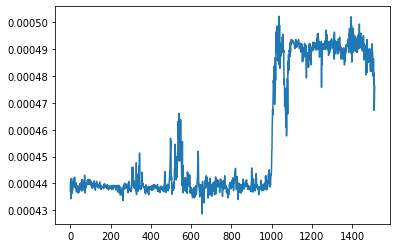

In [164]:
plt.plot(mu)

In [121]:
X1_std

R    0.01363
dtype: float64

0.00018505564

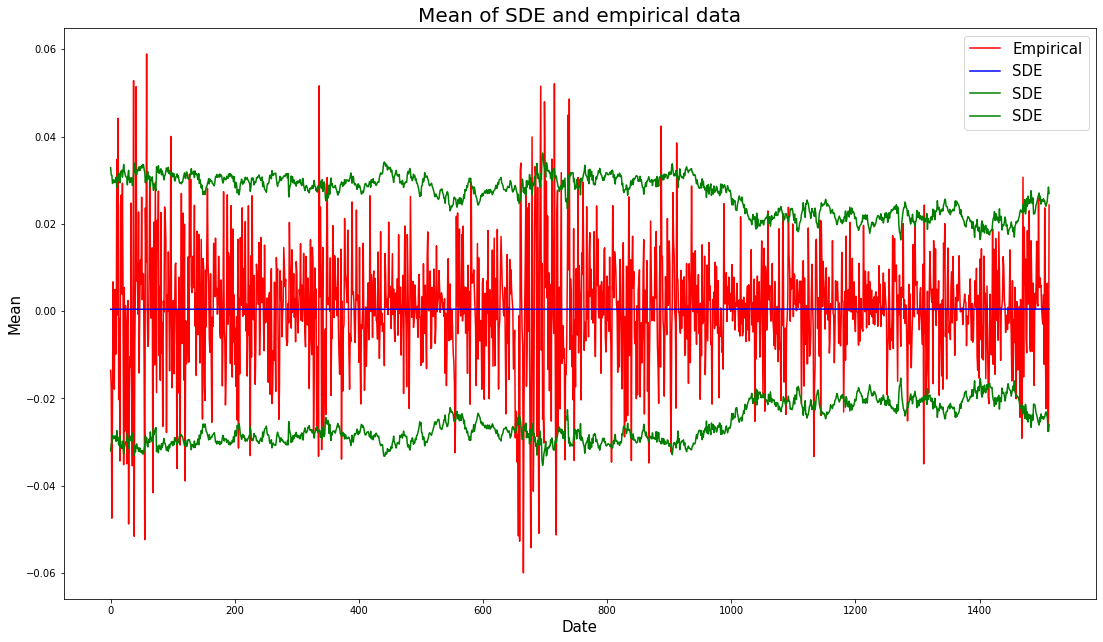

In [105]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu,color='blue',label='SDE')
plt.plot(mu+1.95*sigma,color='green',label='SDE')
plt.plot(mu-1.95*sigma,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

np.mean((y_train_reg*X1_std[0]+X1_mean[0]-mu)**2)

In [106]:
mu

array([0.00043713, 0.00044014, 0.00044109, ..., 0.00046715, 0.00047091,
       0.00047618], dtype=float32)

In [107]:
res = y_train_reg*X1_std[0]+X1_mean[0]-mu

adf, p, usedlag, nobs, cvs,aic = sm.tsa.stattools.adfuller(res)
print(adf,p)

adf2, p2, usedlag2, nobs2, cvs2,aic2 = sm.tsa.stattools.adfuller(res**2)
print(adf2,p2)

-27.731733307745326 0.0
-3.675668659283445 0.004468708358348027


In [108]:
alpha_test = params['alpharnn']['model'].predict(x_test_reg)
# mu_test = alpha_test[:,0]*dt
# sigma_test = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)

0.00013631747294387084
0.012093596


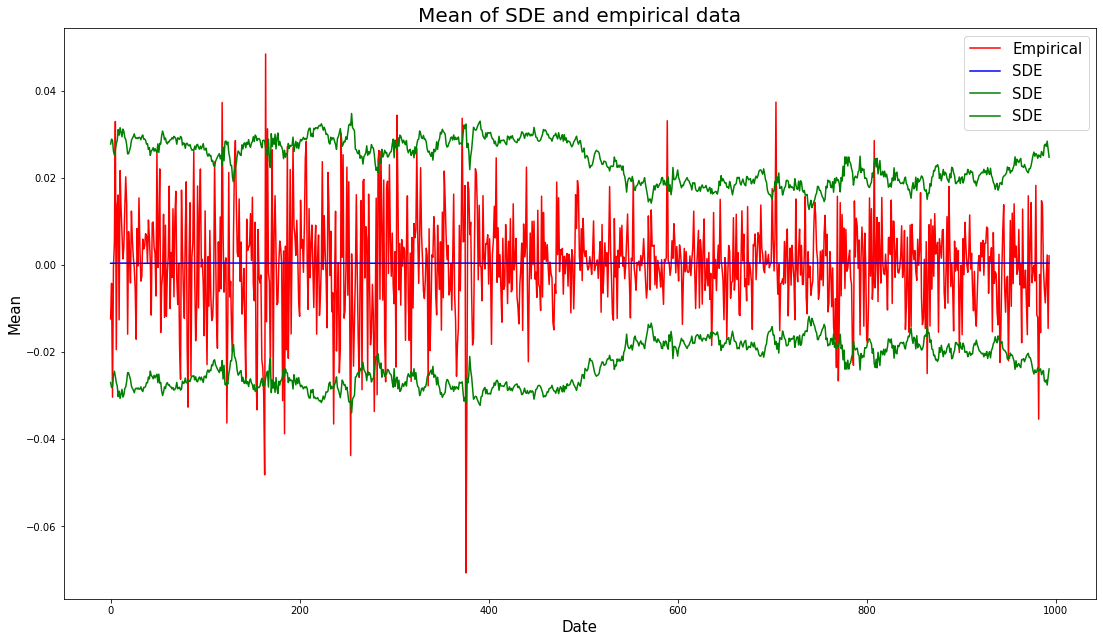

In [111]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test,color='blue',label='SDE')
plt.plot(mu_test+1.95*sigma_test,color='green',label='SDE')
plt.plot(mu_test-1.95*sigma_test,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

print(np.mean((y_test_reg*X1_std[0]+X1_mean[0]-mu_test)**2))
print(np.mean(sigma_test))

In [72]:
from scipy.stats import norm, binom, chi2

quantile = 0.95
refit = 253
test_num = y_test_reg.shape[0]
refit_times = test_num//refit + (test_num%refit > 0)

for key in params.keys():
  model_temp = AlphaRNN_(params[key]['H'],params[key]['l1_reg'])
  rand_seed = 0

  model_name=key
  out_dir='output/checkpoint/'

  pruning_dir = out_dir + 'pruning_summary/'
  
  mu_result = np.array([0])
  sigma_result = np.array([0])
  avg_result = np.array([0])
  for k in range(refit_times):
    end = np.minimum(test_num,k*refit)
    x_train_reg_temp = np.concatenate((x_train_reg,x_test_reg[0:end,:,:]),axis=0) 
    y_train_reg_temp = np.concatenate((y_train_reg,y_test_reg[0:end]),axis=0) 
    x_test_reg_temp = x_test_reg[end:np.minimum(end+refit,test_num),:,:]
    y_test_reg_temp = y_test_reg[end:np.minimum(end+refit,test_num)]
    if k == 0:
      tag = out_dir + model_name[0] + '_' + str(rand_seed)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'
      model_temp.load_weights(checkpoint_filepath)
    else:
      tag = out_dir + model_name[0] + '_' + str(rand_seed)+ '_' + str(k)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'

      pruning_dir = out_dir + 'pruning_summary/'
      
      if not os.path.exists(pruning_dir):
        os.makedirs(pruning_dir)
      # train the pruned model
      tf.random.set_seed(rand_seed)
      if glob(checkpoint_filepath_all):
        model_temp.load_weights(checkpoint_filepath)
      else:
        model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
        csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
        history = model_temp.fit(x_train_reg_temp,y_train_reg_temp,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    alpha_test = model_temp.predict(x_test_reg_temp)
    mu_test = (alpha_test[:,0]*X1_std[0]+X1_mean[0])*dt
    sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)
    y_test_reg_real = (y_test_reg_temp *X1_std[0]+X1_mean[0])*dt
    VaR = norm.ppf(quantile,loc=mu_test,scale=sigma_test)
    avg = (-y_test_reg_real.reshape(-1,1) > VaR.reshape(-1,1))
    mu_result = np.concatenate((mu_result,mu_test),axis=0)
    sigma_result = np.concatenate((sigma_result,sigma_test),axis=0)
    avg_result = np.concatenate((avg_result,avg.reshape(-1,)),axis=0)


lower_bd = binom.ppf(0.025, test_num, 1-quantile)
upper_bd = binom.ppf(0.975, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
mu_result = mu_result[1:]
sigma_result = sigma_result[1:]
avg_result = avg_result[1:]


  

Streaming output truncated to the last 5000 lines.
Epoch 3501/6000
2272/2272 [==============================] - 0s 38us/step - loss: 6122652.3371
Epoch 3502/6000
2272/2272 [==============================] - 0s 35us/step - loss: 6122652.2997
Epoch 3503/6000
2272/2272 [==============================] - 0s 43us/step - loss: 6122652.2174
Epoch 3504/6000
2272/2272 [==============================] - 0s 51us/step - loss: 6122652.1276
Epoch 3505/6000
2272/2272 [==============================] - 0s 38us/step - loss: 6122651.8739
Epoch 3506/6000
2272/2272 [==============================] - 0s 35us/step - loss: 6122651.6202
Epoch 3507/6000
2272/2272 [==============================] - 0s 39us/step - loss: 6122651.5341
Epoch 3508/6000
2272/2272 [==============================] - 0s 40us/step - loss: 6122640.0044
Epoch 3509/6000
2272/2272 [==============================] - 0s 40us/step - loss: 6122639.9707
Epoch 3510/6000
2272/2272 [==============================] - 0s 47us/step - loss: 6122639.9371

In [73]:
VaR_all = norm.ppf(quantile,loc=mu_result,scale=sigma_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

49
0.04929577464788732


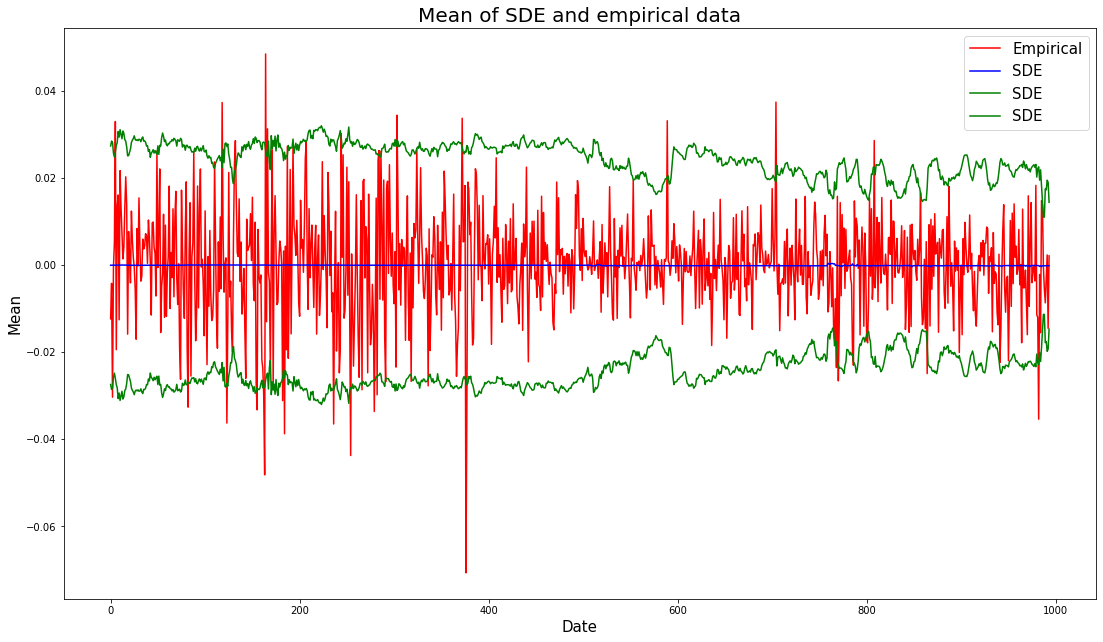

In [74]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_result,color='blue',label='SDE')
plt.plot(mu_result+1.95*sigma_result,color='green',label='SDE')
plt.plot(mu_result-1.95*sigma_result,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

In [75]:
lower_bd = binom.ppf(0.025, test_num, 1-quantile)
upper_bd = binom.ppf(0.975, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))
print(lower_bd)
print(upper_bd)

0.046935563329324914
37.0
65.0


In [76]:
!pip install vartests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 48.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.3/912.3 KB 40.9 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.8.0 requires scipy>=1.5.0, but you have scipy 1.4.1 which is incompatible.


In [77]:
import vartests as vr

vr.duration_test(avg_all, conf_level=0.95)


0.2.0.1
b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


{'weibull exponential': array([2.]),
 'unrestricted log-likelihood': -10000000000.0,
 'restricted log-likelihood': -10000000000.0,
 'log-likelihood': 0.0,
 'log-likelihood ratio test statistic': 1.0,
 'null hypothesis': 'Duration Between Exceedances have no memory (Weibull b=1 = Exponential)',
 'decision': 'Fail to Reject H0'}

In [159]:
class Loss(object):
  def loss_lnS(y_true, y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]
    dX = y_true
            
    # compute log-likelihood
    l = tf.reduce_sum(-gamma + tf.square(dX - (alpha)*dt)*tf.exp(gamma)/dt )
    return l
  
  def loss_lnS_std(y_true,y_pred):
    alpha = y_pred[:,0]
    gamma = y_pred[:,1]

    nu = tf.reduce_min(tf.math.abs(y_pred[:,2]))/100000
    # nu = tf.math.maximum(1,nu)
    
    dX = y_true

    l = tf.reduce_sum(-gamma + (nu+1)*tf.math.log(1+tf.square(dX - (alpha)*dt)*tf.exp(gamma)/dt/nu) +2*tf.math.lgamma(nu/2)-2*tf.math.lgamma((nu+1)/2)+tf.math.log(nu))

    return l

In [160]:
def AlphaRNN_std_(n_units = 10, dense_units=64, l1_reg=0, seed=0,dt=dt):
  inputs = Input(shape=(x_train_reg.shape[1],x_train_reg.shape[2]))
  in1 = Lambda(lambda x: tf.slice(x,[0,0,0],[-1,-1,x_train_reg1.shape[2]]))(inputs)
  in2 = Lambda(lambda x: tf.slice(x,[0,0,x_train_reg1.shape[2]],[-1,-1,-1]))(inputs)
  x1 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg1.shape[1], x_train_reg1.shape[-1]), unroll=True)(in1)
  x2 = AlphaRNN(n_units, activation='tanh', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), recurrent_initializer=keras.initializers.orthogonal(seed), kernel_regularizer=l1(l1_reg), input_shape=(x_train_reg2.shape[1], x_train_reg2.shape[-1]), unroll=True)(in2)
  x1 = Dense(dense_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  x2 = Dense(dense_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  x3 = Dense(dense_units, activation='relu', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out1 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x1)
  out2 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x2)
  out3 = Dense(1, kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed), kernel_regularizer=l1(l1_reg))(x3)
  out =  Lambda(lambda x :K.concatenate(x,1))([out1,out2,out3])
  Mymodel = Model(inputs=inputs,outputs=out)

  Mymodel.compile(loss=Loss.loss_lnS_std, optimizer='adam')
  return Mymodel

In [161]:
def custom_loss_function_std(y_true, y_pred):
    alpha = y_pred[:,0].astype('float32')
    gamma = y_pred[:,1].astype('float32')

    nu = np.amin(np.abs(y_pred[:,2]))/100000
           
    # compute log-likelihood
    
    score = -np.sum(-gamma + (nu+1)/2*np.log(1+np.square(y_true - (alpha)*dt)*np.exp(gamma)/dt/nu) +2*tf.math.lgamma(nu/2)-2*tf.math.lgamma((nu+1)/2)+np.log(nu))

    return score

scorer_std = make_scorer(custom_loss_function_std, greater_is_better=True)

In [162]:
params = {'alpharnn_std': {'model':'', 'function':AlphaRNN_std_,'l1_reg':0.0, 'H':10, 'D':64,'color': 'green', 'label': '$\\alpha$-RNN_std' }}

In [163]:
cross_val=True # Warning: Changing this to True will take several hours to run
if cross_val:
    n_units = [5,10,20,50]
    l1_reg = [0, 0.001, 0.01, 0.1]
    dense_units = [32,64,128]

    tscv = TimeSeriesSplit(n_splits = 2)
    param_grid = dict(n_units=n_units,dense_units=dense_units,l1_reg=l1_reg)

    for key in params.keys(): # params[key]['function']
        model = KerasRegressor(build_fn=params[key]['function'], epochs=max_epoches, batch_size=batch_size, verbose=2)
        grid = GridSearchCV(estimator=model,param_grid=param_grid,scoring=scorer_std,error_score="raise",cv=tscv, n_jobs=1, verbose=2)
        grid_result = grid.fit(x_train_reg,y_train_reg,callbacks=[es])
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params_ = grid_result.cv_results_['params']
        for mean, stdev, param_ in zip(means, stds, params_):
            print("%f (%f) with %r" % (mean, stdev, param_))

        params[key]['H'] = grid_result.best_params_['n_units']
        params[key]['l1_reg']= grid_result.best_params_['l1_reg']
        params[key]['D']= grid_result.best_params_['dense_units']

        joblib.dump(grid, key + 'grid_std.pkl')

Streaming output truncated to the last 5000 lines.
Epoch 829/6000
 - 0s - loss: 8243142.6515
Epoch 830/6000
 - 0s - loss: 8204032.8944
Epoch 831/6000
 - 0s - loss: 8199756.2421
Epoch 832/6000
 - 0s - loss: 8191394.1114
Epoch 833/6000
 - 0s - loss: 8187894.6196
Epoch 834/6000
 - 0s - loss: 8193925.3118
Epoch 835/6000
 - 0s - loss: 8208950.2561
Epoch 836/6000
 - 0s - loss: 8193450.1827
Epoch 837/6000
 - 0s - loss: 8194246.9833
Epoch 838/6000
 - 0s - loss: 8223014.5099
Epoch 839/6000
 - 0s - loss: 8136707.3643
Epoch 840/6000
 - 0s - loss: 8128426.7386
Epoch 841/6000
 - 0s - loss: 8200540.2708
Epoch 842/6000
 - 0s - loss: 8120883.3136
Epoch 843/6000
 - 0s - loss: 8173355.2621
Epoch 844/6000
 - 0s - loss: 8201526.3619
Epoch 845/6000
 - 0s - loss: 8207459.5152
Epoch 846/6000
 - 0s - loss: 8152941.8230
Epoch 847/6000
 - 0s - loss: 8148982.4108
Epoch 848/6000
 - 0s - loss: 8157709.7037
Epoch 849/6000
 - 0s - loss: 8104289.9554
Epoch 850/6000
 - 0s - loss: 8128175.1148
Epoch 851/6000
 - 0s - lo

In [164]:
#load your model for further usage
# joblib.load("model_file_name.pkl")

params

{'alpharnn_std': {'model': '',
  'function': <function __main__.AlphaRNN_std_(n_units=10, dense_units=64, l1_reg=0, seed=0, dt=0.0027397260273972603)>,
  'l1_reg': 0,
  'H': 5,
  'D': 64,
  'color': 'green',
  'label': '$\\alpha$-RNN_std'}}

In [165]:
# l1_reg': 0.001, H = 5, D = 64
from keras.callbacks.callbacks import ModelCheckpoint, CSVLogger

for key in params.keys():
  rand_seed = 0
  tf.compat.v1.set_random_seed(rand_seed)
  model=params[key]['function'](params[key]['H'],params[key]['D'],params[key]['l1_reg'])

  model_name=key
  out_dir='output/checkpoint/'

  tag = out_dir + model_name[0] + '_std_' + str(rand_seed)
  checkpoint_filepath = tag
  checkpoint_filepath_all = tag + '*'
  csv_fname = tag + '_history.csv'

  pruning_dir = out_dir + 'pruning_summary/'
  if not os.path.exists(pruning_dir):
    os.makedirs(pruning_dir)

  # train the pruned model
  tf.random.set_seed(rand_seed)
  if glob(checkpoint_filepath_all):
    model.load_weights(checkpoint_filepath)
  else:
    model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
    csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
    
    history = model.fit(x_train_reg,y_train_reg,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    # plot training loss history
    plot_fname = tag + '_history.png'
    hist = pd.DataFrame(history.history)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()

    plt.savefig(plot_fname, dpi=500)
    plt.close()
  params[key]['model']=model


Streaming output truncated to the last 5000 lines.
1513/1513 [==============================] - 0s 56us/step - loss: 11178564.2082
Epoch 3502/6000
1513/1513 [==============================] - 0s 42us/step - loss: 11177266.5276
Epoch 3503/6000
1513/1513 [==============================] - 0s 51us/step - loss: 11175910.9215
Epoch 3504/6000
1513/1513 [==============================] - 0s 44us/step - loss: 11174626.1550
Epoch 3505/6000
1513/1513 [==============================] - 0s 46us/step - loss: 11173308.2224
Epoch 3506/6000
1513/1513 [==============================] - 0s 48us/step - loss: 11172026.2004
Epoch 3507/6000
1513/1513 [==============================] - 0s 42us/step - loss: 11170710.0307
Epoch 3508/6000
1513/1513 [==============================] - 0s 43us/step - loss: 11169394.0993
Epoch 3509/6000
1513/1513 [==============================] - 0s 45us/step - loss: 11168096.0476
Epoch 3510/6000
1513/1513 [==============================] - 0s 37us/step - loss: 11166773.0314
Epoch

<Figure size 648x180 with 0 Axes>

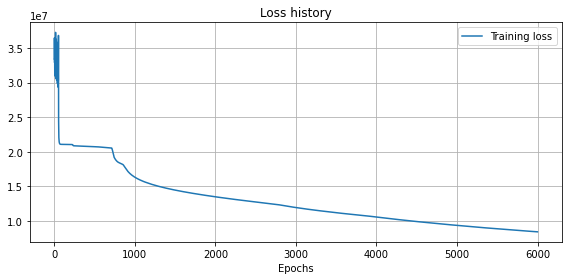

In [166]:
rand_seed = 0
fig = plt.figure(figsize=(9, 2.5))
for key in params.keys():
    model_name=key
    out_dir='output/checkpoint/'
    tag = out_dir + model_name[0] + '_std_' + str(rand_seed)
    csv_fname = tag + '_history.csv'
    df_hist = pd.read_csv(csv_fname, index_col=0)

    fig = plt.figure(figsize=(8, 4))
    ax = fig.add_subplot(111)
    ax.set_title(fr'Loss history')
    ax.plot(hist['loss'], label='Training loss')
    ax.set_xlabel('Epochs')
    ax.legend()
    plt.grid()
    plt.tight_layout()


In [ ]:
# for key in params.keys():
#   params[key]['model'].save(key + 'std.hdf5', overwrite=True)  # creates a HDF5 file
# for key in params.keys():
#   params[key]['model']=load_model(key + 'std.hdf5')

In [168]:
import scipy.stats

alpha = params['alpharnn_std']['model'].predict(x_train_reg)
mu = alpha[:,0]*dt*X1_std[0]+X1_mean[0]
sigma = np.exp(-alpha[:,1]/2)*X1_std[0]*np.sqrt(dt)
nu = np.amin(np.abs(alpha[:,2]))/100000
print(nu)
ci = scipy.stats.t.ppf(q=0.05,df=np.round(nu))

0.043233046875


In [170]:
nu

0.043233046875

0.0001869703

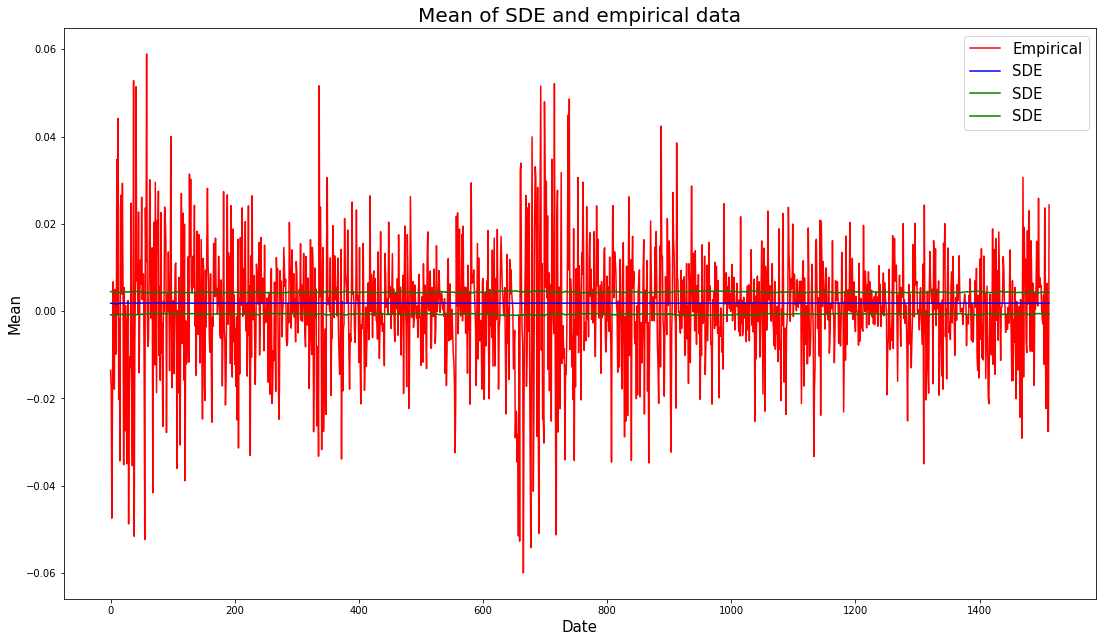

In [169]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_train_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu,color='blue',label='SDE')
plt.plot(mu+1.95*sigma,color='green',label='SDE')
plt.plot(mu-1.95*sigma,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

np.mean((y_train_reg*X1_std[0]+X1_mean[0]-mu)**2)

In [ ]:
res = y_train_reg*X1_std[0]+X1_mean[0]-mu

adf, p, usedlag, nobs, cvs,aic = sm.tsa.stattools.adfuller(res)
print(adf,p)

adf2, p2, usedlag2, nobs2, cvs2,aic2 = sm.tsa.stattools.adfuller(res**2)
print(adf2,p2)

In [ ]:
alpha_test = params['alpharnn']['model'].predict(x_test_reg)
# mu_test = alpha_test[:,0]*dt
# sigma_test = np.exp(-alpha_test[:,1]/2)*np.sqrt(dt)
mu_test = alpha_test[:,0]*dt*X1_std[0]+X1_mean[0]
sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
plt.plot(y_test_reg*X1_std[0]+X1_mean[0],color='red',label='Empirical')
plt.plot(mu_test,color='blue',label='SDE')
plt.plot(mu_test+1.95*sigma_test,color='green',label='SDE')
plt.plot(mu_test-1.95*sigma_test,color='green',label='SDE')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Mean',fontsize=15)
plt.title('Mean of SDE and empirical data',fontsize=20)
plt.legend(fontsize=15)

print(np.mean((y_test_reg*X1_std[0]+X1_mean[0]-mu_test)**2))
print(np.mean(sigma_test))

In [ ]:
from scipy.stats import norm, binom, chi2, t

quantile = 0.95
refit = 253
test_num = y_test_reg.shape[0]
refit_times = test_num//refit + (test_num%refit > 0)

for key in params.keys():
  model_temp = AlphaRNN_std_(params[key]['H'],params[key]['D'],params[key]['l1_reg'])
  rand_seed = 0

  model_name=key
  out_dir='output/checkpoint/'

  pruning_dir = out_dir + 'pruning_summary/'
  
  mu_result = np.array([0])
  sigma_result = np.array([0])
  nu_result = np.array([0])
  for k in range(refit_times):
    end = np.minimum(test_num,k*refit)
    x_train_reg_temp = np.concatenate((x_train_reg,x_test_reg[0:end,:,:]),axis=0) 
    y_train_reg_temp = np.concatenate((y_train_reg,y_test_reg[0:end]),axis=0) 
    x_test_reg_temp = x_test_reg[end:np.minimum(end+refit,test_num),:,:]
    y_test_reg_temp = y_test_reg[end:np.minimum(end+refit,test_num)]
    if k == 0:
      tag = out_dir + model_name[0] + '_std_' + str(rand_seed)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'
      model_temp.load_weights(checkpoint_filepath)
    else:
      tag = out_dir + model_name[0] + '_std_' + str(rand_seed)+ '_' + str(k)
      checkpoint_filepath = tag
      checkpoint_filepath_all = tag + '*'
      csv_fname = tag + '_history.csv'

      pruning_dir = out_dir + 'pruning_summary/'
      
      if not os.path.exists(pruning_dir):
        os.makedirs(pruning_dir)
      # train the pruned model
      tf.random.set_seed(rand_seed)
      if glob(checkpoint_filepath_all):
        model_temp.load_weights(checkpoint_filepath)
      else:
        model_checkpoint_callback = ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=True,
                monitor='loss',
                mode='min',
                save_best_only=True)
        csv_logger = CSVLogger(
                filename=csv_fname,
                separator=',',
                append=False
            )
        history = model_temp.fit(x_train_reg_temp,y_train_reg_temp,epochs=max_epoches, 
                        batch_size=batch_size,
                        callbacks=[es,model_checkpoint_callback,
                                   csv_logger],
                        shuffle=False)

    alpha_train = model_temp.predict(x_train_reg_temp)
    alpha_test = model_temp.predict(x_test_reg_temp)
    mu_test = (alpha_test[:,0]*X1_std[0]+X1_mean[0])*dt
    sigma_test = np.exp(-alpha_test[:,1]/2)*X1_std[0]*np.sqrt(dt)
    nu_test = np.amin(np.abs(alpha_train[:,2]))/100000*np.ones(mu_test.shape)
    y_test_reg_real = (y_test_reg_temp *X1_std[0]+X1_mean[0])*dt
    mu_result = np.concatenate((mu_result,mu_test),axis=0)
    sigma_result = np.concatenate((sigma_result,sigma_test),axis=0)
    nu_result = np.concatenate((nu_result,nu_test),axis=0)

mu_result = mu_result[1:]
sigma_result = sigma_result[1:]
nu_result = nu_result[1:]

lower_bd = binom.ppf(0.025, test_num, 1-quantile)
upper_bd = binom.ppf(0.975, test_num, 1-quantile)+1

print(binom.cdf(lower_bd, test_num, 1-quantile) +1- binom.cdf(upper_bd, test_num, 1-quantile))

In [ ]:
VaR_all = t.ppf(quantile,loc=mu_result,scale=sigma_result,df=nu_result)
y_test_unnorm = y_test_reg*X1_std[0]+X1_mean[0]
avg_all = (-y_test_unnorm.reshape(-1,1) > VaR_all.reshape(-1,1))
print(np.sum(avg_all))
print(np.sum(avg_all)/test_num)

In [ ]:
import vartests as vr

vr.duration_test(avg_all, conf_level=0.95)